In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantbullet.preprocessing.transformers import FlatRampTransformer
from quantbullet.dfutils import get_bins_and_labels

In [3]:
np.random.seed(42)
n_samples = 1_000_000
x1 = np.random.uniform(0, 4, n_samples)
x2 = np.random.uniform(4, 8, n_samples)
y = ( x1 - 2 ) ** 2 + ( x2 - 6 ) ** 3 + np.random.normal(0, 1, n_samples) + 10

df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})

In [4]:
x1_trans = FlatRampTransformer(
    knots = [1, 2, 3],
    include_bias=True
)

x2_trans = FlatRampTransformer(
    knots = [5, 6, 7],
    include_bias=True
)

train_df = np.concatenate([
    x1_trans.fit_transform(df['x1']),
    x2_trans.fit_transform(df['x2']),
], axis=1)

train_df = pd.DataFrame(train_df, columns = x1_trans.get_feature_names_out().tolist() 
                        + x2_trans.get_feature_names_out().tolist())

In [5]:
x1_bins, x1_labels = get_bins_and_labels(cutoffs=np.arange(0.2, 4, 0.2))
x2_bins, x2_labels = get_bins_and_labels(cutoffs=np.arange(4.2, 8, 0.2))
df['x1_bins'] = pd.cut( df['x1'], bins=x1_bins, labels=x1_labels )
df['x2_bins'] = pd.cut( df['x2'], bins=x2_bins, labels=x2_labels )

In [7]:
feature_groups = {'x1': x1_trans.get_feature_names_out().tolist(), 
                  'x2': x2_trans.get_feature_names_out().tolist(),}

In [8]:
from quantbullet.optimizer import LinearProductRegressionModelOLS

lprm_ols = LinearProductRegressionModelOLS()

In [9]:
lprm_ols.fit( train_df, df['y'], feature_groups=feature_groups, n_iterations=10, early_stopping_rounds=5 )

Iteration 1/10, MSE: 1.1876
Iteration 2/10, MSE: 1.2209
Iteration 3/10, MSE: 1.2209
Iteration 4/10, MSE: 1.2209
Iteration 5/10, MSE: 1.2209
Iteration 6/10, MSE: 1.2209
Early stopping at iteration 6 with MSE: 1.2209


In [10]:
df['model_predict'] = lprm_ols.predict(train_df)

In [11]:
lprm_ols.coef_dict

{'x1': {'x1_bias': np.float64(0.12296482161589115),
  'x1_le_1': np.float64(-0.13015946666495584),
  'x1_1_2': np.float64(-0.04320275372270867),
  'x1_2_3': np.float64(0.04317054444691587),
  'x1_gt_3': np.float64(0.12993127931015175)},
 'x2': {'x2_bias': np.float64(-167.76749557456367),
  'x2_le_5': np.float64(15.053540839078105),
  'x2_5_6': np.float64(1.0503844438788654),
  'x2_6_7': np.float64(1.0813388627263656),
  'x2_gt_7': np.float64(15.009226299902434)}}

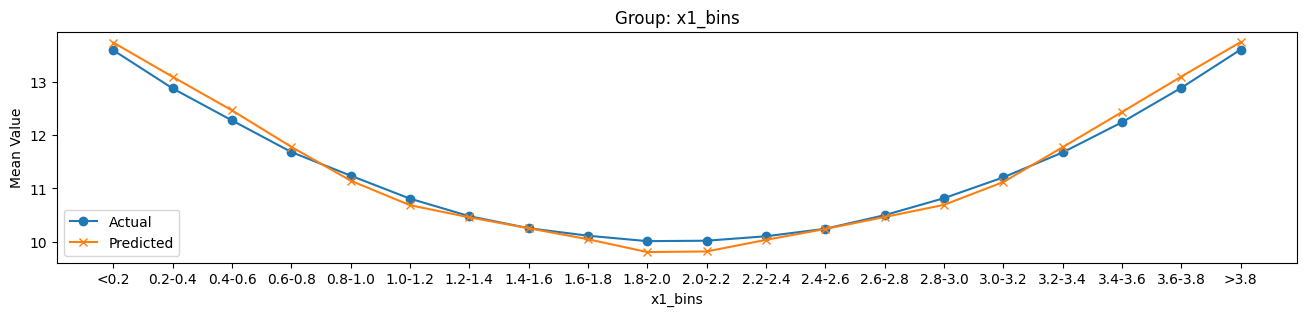

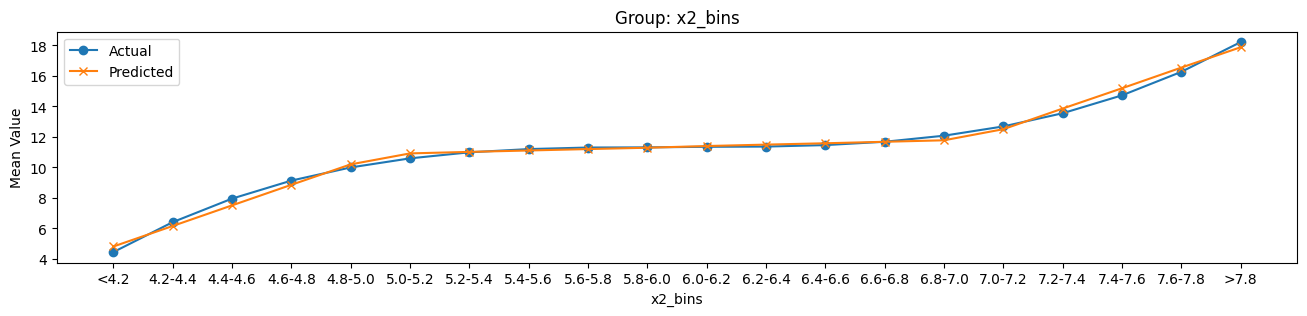

In [12]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'y': 'mean', 'model_predict': 'mean'})
    plt.plot(summary.index, summary['y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['model_predict'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()